### Import the relevant packages 

In [104]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tabulate import tabulate

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn import tree

In [3]:
train_data = pd.read_csv('train_data.csv',index_col=0)
test_data = pd.read_csv('test_data.csv',index_col=0)
train_data.index = range(len(train_data))
train_data.loc[train_data['OCCUPATION']!=1,'OCCUPATION'] = 0
test_data.index = range(len(test_data))
test_data.loc[test_data['OCCUPATION']!=1,'OCCUPATION'] = 0

## Prepping data

In [4]:
# first, we list all the categorical variables to be one hot encoded
cat_vars = ['MARRIAGE', 'EDUCATION']

In [5]:
# create an encoder for each cat_vars
encoders = [OneHotEncoder(categories='auto') for _ in range(len(cat_vars))] 
# encode each of the cat_vars with their respective encoder
encoded_tr = [encoders[i].fit_transform(train_data[[cat_var]]).todense() for i,cat_var in enumerate(cat_vars)]
encoded_test = [encoders[i].fit_transform(test_data[[cat_var]]).todense() for i,cat_var in enumerate(cat_vars)]

In [6]:
# drop the label column and also drop the cat_vars 
# this way we can combine the encoded categorical variables with the continuous variables 
X_train = pd.concat([train_data.iloc[:,:-1].drop(cat_vars, axis=1), 
                     pd.DataFrame(np.concatenate(encoded_tr, axis=1))], axis=1)
X_test = pd.concat([test_data.iloc[:,:-1].drop(cat_vars, axis=1), 
                    pd.DataFrame(np.concatenate(encoded_test, axis=1))], axis=1)
y_train = train_data.iloc[:,-1] 
y_test = test_data.iloc[:,-1]
X_train = X_train.rename(columns={0:'Marriage 1',1:'Marriage 2',2:'Marriage 3',3:'Edu 1',4:'Edu 2',5:'Edu 3',
                                  6:'Edu 4',7:'Edu 5',8:'Edu 6',9:'Edu 7'})
# Note that in the testing data, we do not have Marriage 3 and Edu 6
X_test = X_test.rename(columns={0:'Marriage 1',1:'Marriage 2',2:'Edu 1',3:'Edu 2',4:'Edu 3',
                                  5:'Edu 4',6:'Edu 5',7:'Edu 7'})

### Normalize continuous features. Note that for the testing data, we still use the mean and standard deviation from the training data to do the normalization.¶

In [7]:
for i in [0,1,2,3,4,5,8]:
    X1 = X_train.iloc[:,i]
    mean = X1.mean()
    std = X1.std()
    X_train.iloc[:,i] = (X1-mean)/std
    X_test.iloc[:,i] = (X_test.iloc[:,i]-mean)/std

In [8]:
X_train.head()

,DEBT,YRS_IN_RESIDENT,AGE,YRS_OF_EMPLOYMENT,DTI,NUM_PREV_APP,OCCUPATION,PROVIDED_SIN,INCOME,CREDIT_PROFILE,Marriage 1,Marriage 2,Marriage 3,Edu 1,Edu 2,Edu 3,Edu 4,Edu 5,Edu 6,Edu 7
0,0.835945,-0.686741,-1.085931,-0.642788,-0.074637,-0.555121,0,1,1.530698,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.294264,-1.364851,1.314706,-0.095677,-0.630176,-0.555121,1,1,-0.109336,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.072081,-1.025796,0.238559,-0.045939,1.036440,-0.555121,1,1,1.804037,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.233465,-0.347686,-1.003150,-0.841738,-0.667212,0.153818,0,1,-1.749370,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.309851,1.008535,1.066364,0.451435,-0.185745,-0.555121,0,1,0.164003,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [9]:
X_test.head()

,DEBT,YRS_IN_RESIDENT,AGE,YRS_OF_EMPLOYMENT,DTI,NUM_PREV_APP,OCCUPATION,PROVIDED_SIN,INCOME,CREDIT_PROFILE,Marriage 1,Marriage 2,Edu 1,Edu 2,Edu 3,Edu 4,Edu 5,Edu 7
0,-0.233465,-1.364851,-0.672028,0.351960,0.962368,-0.555121,1,1,-1.476031,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.683172,-0.008630,0.735242,0.053536,0.814224,0.862758,1,1,0.984020,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.309851,-0.347686,-1.168711,-0.941213,-0.667212,-0.555121,1,0,-0.656014,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,5.189971,1.008535,0.321339,-0.742263,-0.444997,0.390132,0,0,-0.382675,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.157078,1.347590,0.486900,1.048284,0.073506,0.862758,0,1,1.804037,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [10]:
# Get rid of some dummy variables to avoid perfect multicollinearity
X_train = X_train.drop(['Marriage 3','Edu 6'], axis=1)

In [11]:
X_train.head()

,DEBT,YRS_IN_RESIDENT,AGE,YRS_OF_EMPLOYMENT,DTI,NUM_PREV_APP,OCCUPATION,PROVIDED_SIN,INCOME,CREDIT_PROFILE,Marriage 1,Marriage 2,Edu 1,Edu 2,Edu 3,Edu 4,Edu 5,Edu 7
0,0.835945,-0.686741,-1.085931,-0.642788,-0.074637,-0.555121,0,1,1.530698,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.294264,-1.364851,1.314706,-0.095677,-0.630176,-0.555121,1,1,-0.109336,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.072081,-1.025796,0.238559,-0.045939,1.036440,-0.555121,1,1,1.804037,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.233465,-0.347686,-1.003150,-0.841738,-0.667212,0.153818,0,1,-1.749370,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-0.309851,1.008535,1.066364,0.451435,-0.185745,-0.555121,0,1,0.164003,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [12]:
X_test.head()

,DEBT,YRS_IN_RESIDENT,AGE,YRS_OF_EMPLOYMENT,DTI,NUM_PREV_APP,OCCUPATION,PROVIDED_SIN,INCOME,CREDIT_PROFILE,Marriage 1,Marriage 2,Edu 1,Edu 2,Edu 3,Edu 4,Edu 5,Edu 7
0,-0.233465,-1.364851,-0.672028,0.351960,0.962368,-0.555121,1,1,-1.476031,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.683172,-0.008630,0.735242,0.053536,0.814224,0.862758,1,1,0.984020,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.309851,-0.347686,-1.168711,-0.941213,-0.667212,-0.555121,1,0,-0.656014,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,5.189971,1.008535,0.321339,-0.742263,-0.444997,0.390132,0,0,-0.382675,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.157078,1.347590,0.486900,1.048284,0.073506,0.862758,0,1,1.804037,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [13]:
X_train.to_csv('train.csv')

### Import a number of classifiers (feel free to include other classifiers) from sklearn.  <a href="https://xgboost.readthedocs.io/en/latest/index.html" target="_blank">XGBoost</a>  can be installed in Anaconda by using
conda install -c anaconda py-xgboost

In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from xgboost import XGBClassifier

#List of models to train with
models = []
models.append(('Linaer Discriminant Analysis',LinearDiscriminantAnalysis()))
models.append(('Logistic Regression',LogisticRegression()))
models.append(('SVM',LinearSVC(max_iter=10000,dual="auto")))
models.append(('KNN',KNeighborsClassifier()))
models.append(('DecisionTree',DecisionTreeClassifier(random_state=0)))
models.append(('RandomForest',RandomForestClassifier(random_state=0)))
models.append(('GradientBoost',GradientBoostingClassifier(random_state=0)))
models.append(('XGBoost',XGBClassifier(random_state=0,objective='binary:logistic')))

### Fitting various models using the data.   Here we use the default options for each classifier and fit the model using the training data and verify its performance on the testing data. 

In [21]:
for classifier, model in models:
    model.fit(X_train,y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_accuracy = accuracy_score(y_train,y_train_pred)
    test_accuracy = accuracy_score(y_test,y_test_pred)
    TN, FP, FN, TP = confusion_matrix(y_test,y_test_pred,sample_weight=None).ravel()
    TPR = TP/(TP+FN)
    TNR = TN/(TN+FP)
    print("Classifier: {}".format(classifier))    
    print("Accuracy Score on Training Data = {:.4f}".format(train_accuracy))    
    print("Performance on Testing Data:")
    print("Accuracy Score = {:.4f}".format(test_accuracy))    
    print("True Positive Rate = {:.4f}".format(TPR))
    print("True Negative Rate = {:.4f}".format(TNR))
    print("\n")

Classifier: Linaer Discriminant Analysis
Accuracy Score on Training Data = 0.8600
Performance on Testing Data:
Accuracy Score = 0.8714
True Positive Rate = 0.8772
True Negative Rate = 0.8675


Classifier: Logistic Regression
Accuracy Score on Training Data = 0.8691
Performance on Testing Data:
Accuracy Score = 0.8643
True Positive Rate = 0.8596
True Negative Rate = 0.8675


Classifier: KNN
Accuracy Score on Training Data = 0.8582
Performance on Testing Data:
Accuracy Score = 0.8643
True Positive Rate = 0.7895
True Negative Rate = 0.9157


Classifier: DecisionTree
Accuracy Score on Training Data = 1.0000
Performance on Testing Data:
Accuracy Score = 0.8786
True Positive Rate = 0.8246
True Negative Rate = 0.9157


Classifier: RandomForest
Accuracy Score on Training Data = 1.0000
Performance on Testing Data:
Accuracy Score = 0.8714
True Positive Rate = 0.8421
True Negative Rate = 0.8916


Classifier: GradientBoost
Accuracy Score on Training Data = 0.9582
Performance on Testing Data:
Accur

# There are two important decisions to be made.  One is that given a model, how you should choose the tuning parameters.  The other is given that you have multiple models, which one you should use.

### For the first question, one possibility is to use K-fold cross-validation with our custom score function to determine the best tuning parameters.  Here is an example that tunes the shrinkage parameter in the logistic regression.  Note that $C$ is the inverse of the regularization strength.  Smaller $C$ means stronger regularization.

In [74]:
testaccuracy =[]
tpr_list =[]
tnr_list =[]
auc_list=[]

In [75]:
lgr_param_grid = {'C': np.linspace(0.1,10,100)}
lgr = LogisticRegression(penalty='l2')
clf_lgr = GridSearchCV(lgr, lgr_param_grid, cv=3)
clf_lgr.fit(X_train, y_train.ravel())
lgr_reg_params = clf_lgr.best_params_['C']
print("Best regularization parameter = {:.2f}".format(lgr_reg_params))
lgr = LogisticRegression(penalty='l2',C=lgr_reg_params)
lgr.fit(X_train,y_train)                                                       
y_test_pred = lgr.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
TN, FP, FN, TP = confusion_matrix(y_test,y_test_pred,sample_weight=None).ravel()
TPR = TP/(TP+FN)
TNR = TN/(TN+FP)
Q = lgr.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, Q)
roc_auc = auc(fpr,tpr)    
print("Performance on Testing Data:")
print("Accuracy Score = {:.4f}".format(test_accuracy))    
print("True Positive Rate = {:.4f}".format(TPR))
print("True Negative Rate = {:.4f}".format(TNR))
print("AUC = {:.4f}".format(roc_auc))
testaccuracy.append(test_accuracy)
tpr_list.append(TPR)
tnr_list.append(TNR)
auc_list.append(roc_auc)

Best regularization parameter = 0.30
Performance on Testing Data:
Accuracy Score = 0.8786
True Positive Rate = 0.8596
True Negative Rate = 0.8916
AUC = 0.9317


### We could see the impact of different thresholds on the prediction of the logistic regression

In [76]:
THRESHOLD = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
results = pd.DataFrame(columns=["THRESHOLD", "accuracy", "true positive rate", "true negative rate"]) # df to store results
results['THRESHOLD'] = THRESHOLD                                                           # threshold column
Q = lgr.predict_proba(X_test)[:,1]
for i in range(9):                                                                         # iterate over each threshold    
    preds = np.where(Q>THRESHOLD[i], 1, 0)                                                 # if prob > threshold, predict 1   
    test_accuracy = accuracy_score(y_test,preds)
    TN, FP, FN, TP = confusion_matrix(y_test,preds,sample_weight=None).ravel()
    TPR = TP/(TP+FN)
    TNR = TN/(TN+FP)
    results.iloc[i,1] = test_accuracy 
    results.iloc[i,2] = TPR
    results.iloc[i,3] = TNR
print(results.to_string(header=True))

   THRESHOLD  accuracy true positive rate true negative rate
0        0.1  0.714286           0.929825           0.566265
1        0.2  0.842857           0.912281           0.795181
2        0.3  0.864286           0.877193           0.855422
3        0.4  0.857143           0.859649           0.855422
4        0.5  0.878571           0.859649           0.891566
5        0.6  0.892857           0.842105           0.927711
6        0.7  0.871429           0.754386           0.951807
7        0.8  0.814286           0.561404           0.987952
8        0.9  0.742857           0.368421                1.0


C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


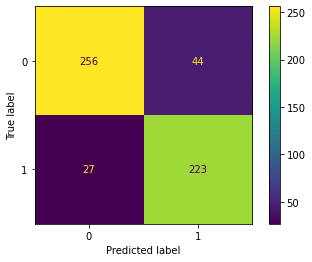

In [77]:
plot_confusion_matrix(clf_lgr,X_train, y_train,values_format='d' )

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


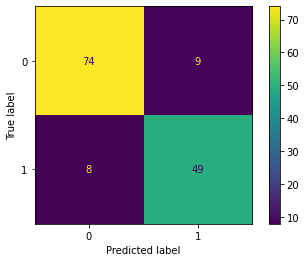

In [78]:
plot_confusion_matrix(clf_lgr,X_test, y_test,values_format='d' )

### We now repeat the exercise with $L_1$ penalty

In [79]:
lgr_param_grid = {'C': np.linspace(0.05,5,100)}
lgr = LogisticRegression(solver='liblinear',penalty='l1')
clf_lgr = GridSearchCV(lgr, lgr_param_grid, cv=3)
clf_lgr.fit(X_train, y_train.ravel())
lgr_reg_params = clf_lgr.best_params_['C']
print("Best regularization parameter = {:.3f}".format(lgr_reg_params))
lgr = LogisticRegression(solver='liblinear',penalty='l1',C=lgr_reg_params)
lgr.fit(X_train,y_train)                                                       
y_test_pred = lgr.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
TN, FP, FN, TP = confusion_matrix(y_test,y_test_pred,sample_weight=None).ravel()
TPR = TP/(TP+FN)
TNR = TN/(TN+FP)
Q = lgr.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, Q)
roc_auc = auc(fpr,tpr)    
print("Performance on Testing Data:")
print("Accuracy Score = {:.4f}".format(test_accuracy))    
print("True Positive Rate = {:.4f}".format(TPR))
print("True Negative Rate = {:.4f}".format(TNR))
print("AUC = {:.4f}".format(roc_auc))

testaccuracy.append(test_accuracy)
tpr_list.append(TPR)
tnr_list.append(TNR)
auc_list.append(roc_auc)

Best regularization parameter = 1.650
Performance on Testing Data:
Accuracy Score = 0.8571
True Positive Rate = 0.8596
True Negative Rate = 0.8554
AUC = 0.9328


In [80]:
THRESHOLD = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
results = pd.DataFrame(columns=["THRESHOLD", "accuracy", "true positive rate", "true negative rate"]) # df to store results
results['THRESHOLD'] = THRESHOLD                                                           # threshold column
Q = lgr.predict_proba(X_test)[:,1]                                        
for i in range(9):                                                                         # iterate over each threshold    
    preds = np.where(Q>THRESHOLD[i], 1, 0)                                                 # if prob > threshold, predict 1   
    test_accuracy = accuracy_score(y_test,preds)
    TN, FP, FN, TP = confusion_matrix(y_test,preds,sample_weight=None).ravel()
    TPR = TP/(TP+FN)
    TNR = TN/(TN+FP)
    results.iloc[i,1] = test_accuracy 
    results.iloc[i,2] = TPR
    results.iloc[i,3] = TNR
print(results.to_string(header=True))


   THRESHOLD  accuracy true positive rate true negative rate
0        0.1  0.778571           0.929825           0.674699
1        0.2  0.864286           0.877193           0.855422
2        0.3  0.864286           0.877193           0.855422
3        0.4  0.857143           0.859649           0.855422
4        0.5  0.857143           0.859649           0.855422
5        0.6       0.9           0.859649           0.927711
6        0.7  0.892857           0.789474           0.963855
7        0.8  0.857143           0.701754           0.963855
8        0.9      0.75           0.385965                1.0


C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


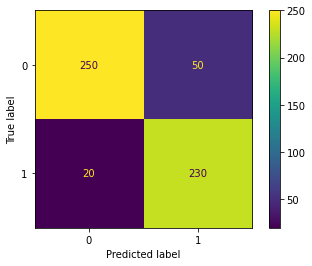

In [81]:
plot_confusion_matrix(clf_lgr,X_train, y_train,values_format='d')

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


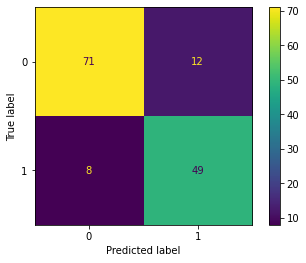

In [82]:
plot_confusion_matrix(clf_lgr,X_test, y_test,values_format='d')

### You would need to come up with a strategy to select the best model, and provide your final recommended model in the last part of the notebook.

## KNN Classifier

In [83]:
k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']
knn = KNeighborsClassifier()
param_grid = dict(n_neighbors=k_range, weights=weight_options)
# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=3, scoring='accuracy', return_train_score=False,verbose=1)
# fitting the model for grid search
grid_search=grid.fit(X_train, y_train.ravel())
print(grid_search.best_params_)
accuracy = grid_search.best_score_
print("Accuracy Score for our training dataset with tuning is {:.4f}".format(accuracy) )

Fitting 3 folds for each of 60 candidates, totalling 180 fits
{'n_neighbors': 8, 'weights': 'distance'}
Accuracy Score for our training dataset with tuning is 0.8273


In [84]:
knn = KNeighborsClassifier(n_neighbors=20, weights='distance')
knn.fit(X_train, y_train)
y_test_hat=knn.predict(X_test)
test_accuracy=accuracy_score(y_test,y_test_hat)
TN, FP, FN, TP = confusion_matrix(y_test,y_test_hat,sample_weight=None).ravel()
TPR = TP/(TP+FN) #precision
TNR = TN/(TN+FP) #recall
Q = knn.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, Q)
roc_auc = auc(fpr,tpr)
print("Performance on Testing Data:")
print("Accuracy Score = {:.4f}".format(test_accuracy))
print("True Positive Rate = {:.4f}".format(TPR))
print("True Negative Rate = {:.4f}".format(TNR))
print("AUC = {:.4f}".format(roc_auc))
testaccuracy.append(test_accuracy)
tpr_list.append(TPR)
tnr_list.append(TNR)
auc_list.append(roc_auc)

Performance on Testing Data:
Accuracy Score = 0.8643
True Positive Rate = 0.7895
True Negative Rate = 0.9157
AUC = 0.9222


In [85]:
THRESHOLD = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
results = pd.DataFrame(columns=["THRESHOLD", "accuracy", "true positive rate", "true negative rate"]) # df to store result
results['THRESHOLD'] = THRESHOLD # threshold column
Q = lgr.predict_proba(X_test)[:,1]
for i in range(9): # iterate over each thres
    preds = np.where(Q>THRESHOLD[i], 1, 0) # if prob > threshold, predi
    test_accuracy = accuracy_score(y_test,preds)
    TN, FP, FN, TP = confusion_matrix(y_test,preds,sample_weight=None).ravel()
    TPR = TP/(TP+FN) #precision
    TNR = TN/(TN+FP) #recall
    results.iloc[i,1] = test_accuracy
    results.iloc[i,2] = TPR
    results.iloc[i,3] = TNR
print(results.to_string(header=True))

   THRESHOLD  accuracy true positive rate true negative rate
0        0.1  0.778571           0.929825           0.674699
1        0.2  0.864286           0.877193           0.855422
2        0.3  0.864286           0.877193           0.855422
3        0.4  0.857143           0.859649           0.855422
4        0.5  0.857143           0.859649           0.855422
5        0.6       0.9           0.859649           0.927711
6        0.7  0.892857           0.789474           0.963855
7        0.8  0.857143           0.701754           0.963855
8        0.9      0.75           0.385965                1.0


C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


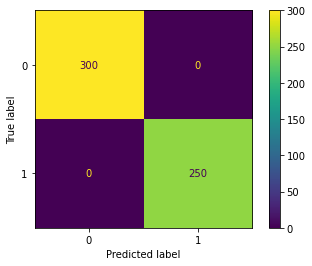

In [86]:
plot_confusion_matrix(grid,X_train, y_train,values_format='d' )

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


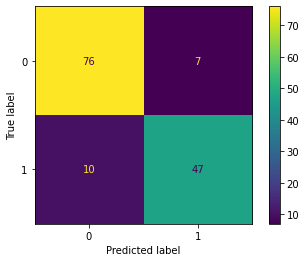

In [87]:
plot_confusion_matrix(grid,X_test, y_test,values_format='d' )

## Decision Tree Classifier

In [88]:
# Training Data Set Used For Accuracy Check
std_slc = StandardScaler()
pca = decomposition.PCA()
dec_tree = tree.DecisionTreeClassifier()
pipe = Pipeline(steps=[('std_slc', std_slc),
('pca', pca),
('dec_tree', dec_tree)])
n_components = list(range(1,X_train.shape[1]+1,1))
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]
parameters = dict(pca__n_components=n_components,
dec_tree__criterion=criterion,
dec_tree__max_depth=max_depth)
clf_GS = GridSearchCV(pipe, parameters, cv=3)
grid_search=clf_GS.fit(X_train, y_train.ravel())
accuracy = grid_search.best_score_
print('Best Criterion:', clf_GS.best_estimator_.get_params()['dec_tree__criterion'])
print('Best max_depth:', clf_GS.best_estimator_.get_params()['dec_tree__max_depth'])
print('Best Number Of Components:', clf_GS.best_estimator_.get_params()['pca__n_components'])
print(); print(clf_GS.best_estimator_.get_params()['dec_tree'])
print("Accuracy Score for our training dataset with tuning is {:.4f}".format(accuracy) )

Best Criterion: gini
Best max_depth: 4
Best Number Of Components: 14

DecisionTreeClassifier(max_depth=4)
Accuracy Score for our training dataset with tuning is 0.8237


In [89]:
# Testing Accuracy on Testing Data
dec_tree1 = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4)
dec_tree1.fit(X_train, y_train.ravel())
y_test_hat = dec_tree1.predict(X_test)
test_accuracy=accuracy_score(y_test,y_test_hat)
TN, FP, FN, TP = confusion_matrix(y_test,y_test_hat,sample_weight=None).ravel()
TPR = TP/(TP+FN) #precision
TNR = TN/(TN+FP) #recall
Q = dec_tree1.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, Q)
roc_auc = auc(fpr,tpr)
print("Performance on Testing Data:")
print("Accuracy Score = {:.4f}".format(test_accuracy))
print("True Positive Rate = {:.4f}".format(TPR))
print("True Negative Rate = {:.4f}".format(TNR))
print("AUC = {:.4f}".format(roc_auc))
testaccuracy.append(test_accuracy)
tpr_list.append(TPR)
tnr_list.append(TNR)
auc_list.append(roc_auc)

Performance on Testing Data:
Accuracy Score = 0.8857
True Positive Rate = 0.8421
True Negative Rate = 0.9157
AUC = 0.9160


In [90]:
THRESHOLD = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
results = pd.DataFrame(columns=["THRESHOLD", "accuracy", "true positive rate", "true negative rate"]) # df to store result
results['THRESHOLD'] = THRESHOLD # threshold column
Q = dec_tree1.predict_proba(X_test)[:,1]
for i in range(9): # iterate over each thres
    preds = np.where(Q>THRESHOLD[i], 1, 0) # if prob > threshold, predi
    test_accuracy = accuracy_score(y_test,preds)
    TN, FP, FN, TP = confusion_matrix(y_test,preds,sample_weight=None).ravel()
    TPR = TP/(TP+FN) #precision
    TNR = TN/(TN+FP) #recall
    results.iloc[i,1] = test_accuracy
    results.iloc[i,2] = TPR
    results.iloc[i,3] = TNR
print(results.to_string(header=True))

   THRESHOLD  accuracy true positive rate true negative rate
0        0.1  0.878571           0.912281           0.855422
1        0.2  0.878571           0.912281           0.855422
2        0.3  0.878571           0.912281           0.855422
3        0.4  0.885714           0.842105           0.915663
4        0.5  0.885714           0.842105           0.915663
5        0.6  0.885714           0.842105           0.915663
6        0.7  0.885714           0.842105           0.915663
7        0.8  0.857143           0.719298           0.951807
8        0.9       0.8           0.561404           0.963855


C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


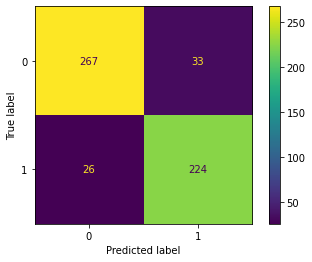

In [91]:
plot_confusion_matrix(clf_GS,X_train, y_train,values_format='d' )

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


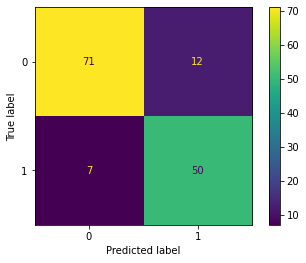

In [92]:
plot_confusion_matrix(clf_GS,X_test, y_test,values_format='d' )

## Linear Discriminant Analysis

In [93]:
LDA_param_grid = {'solver' : ['svd','lsqr','eigen']}
LDA = LinearDiscriminantAnalysis()
clf_LDA = GridSearchCV(LDA, LDA_param_grid, cv=3)
clf_LDA.fit(X_train, y_train.ravel())
LDA_best_param = clf_LDA.best_estimator_.get_params()['solver']
print("Best parameter = ",LDA_best_param)
LDA = LinearDiscriminantAnalysis(solver=LDA_best_param)
LDA.fit(X_train,y_train)
y_test_pred = LDA.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
TN, FP, FN, TP = confusion_matrix(y_test,y_test_pred,sample_weight=None).ravel()
TPR = TP/(TP+FN) #precision
TNR = TN/(TN+FP) #recall
Q = LDA.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, Q)
roc_auc = auc(fpr,tpr)
print("Performance on Testing Data:")
print("Accuracy Score = {:.4f}".format(test_accuracy))
print("True Positive Rate = {:.4f}".format(TPR))
print("True Negative Rate = {:.4f}".format(TNR))
print("AUC = {:.4f}".format(roc_auc))
testaccuracy.append(test_accuracy)
tpr_list.append(TPR)
tnr_list.append(TNR)
auc_list.append(roc_auc)

Best parameter =  svd
Performance on Testing Data:
Accuracy Score = 0.8714
True Positive Rate = 0.8772
True Negative Rate = 0.8675
AUC = 0.9269


In [94]:
THRESHOLD = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
results = pd.DataFrame(columns=["THRESHOLD", "accuracy", "true positive rate", "true negative rate"]) # df to store result
results['THRESHOLD'] = THRESHOLD # threshold column
Q = LDA.predict_proba(X_test)[:,1]
for i in range(9): # iterate over each thres
    preds = np.where(Q>THRESHOLD[i], 1, 0) # if prob > threshold, predi
    test_accuracy = accuracy_score(y_test,preds)
    TN, FP, FN, TP = confusion_matrix(y_test,preds,sample_weight=None).ravel()
    TPR = TP/(TP+FN) #precision
    TNR = TN/(TN+FP) #recall
    results.iloc[i,1] = test_accuracy
    results.iloc[i,2] = TPR
    results.iloc[i,3] = TNR
print(results.to_string(header=True))

   THRESHOLD  accuracy true positive rate true negative rate
0        0.1  0.864286           0.877193           0.855422
1        0.2  0.864286           0.877193           0.855422
2        0.3  0.864286           0.877193           0.855422
3        0.4  0.871429           0.877193            0.86747
4        0.5  0.871429           0.877193            0.86747
5        0.6  0.864286           0.859649            0.86747
6        0.7  0.864286           0.859649            0.86747
7        0.8       0.9           0.859649           0.927711
8        0.9  0.864286           0.719298           0.963855


C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


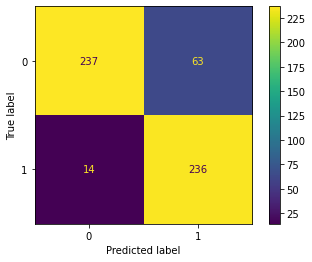

In [95]:
plot_confusion_matrix(clf_LDA,X_train, y_train,values_format='d')

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


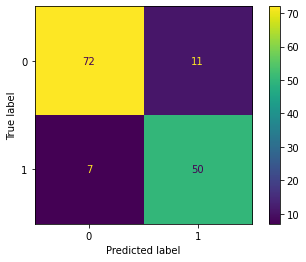

In [96]:
plot_confusion_matrix(clf_LDA,X_test, y_test,values_format='d')

## Random Forest

In [97]:
# Create the parameter grid based on the results of random search
param_grid = {
'bootstrap': [True],
'max_depth': [80, 90, 100, 110],
'max_features': [2, 3],
'min_samples_leaf': [3, 4, 5],
'min_samples_split': [8, 10, 12],
'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [98]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
print('Best Parameters are:-\n',grid_search.best_params_)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
Best Parameters are:-
 {'bootstrap': True, 'max_depth': 90, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 12, 'n_estimators': 100}


In [99]:
best_grid = grid_search.best_estimator_
best_grid.fit(X_train,y_train)
y_test_pred = best_grid.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
TN, FP, FN, TP = confusion_matrix(y_test,y_test_pred,sample_weight=None).ravel()
TPR = TP/(TP+FN) #precision
TNR = TN/(TN+FP) #recall
Q = best_grid.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, Q)
roc_auc = auc(fpr,tpr)
print("Performance on Testing Data:")
print("Accuracy Score = {:.4f}".format(test_accuracy))
print("True Positive Rate = {:.4f}".format(TPR))
print("True Negative Rate = {:.4f}".format(TNR))
print("AUC = {:.4f}".format(roc_auc))
testaccuracy.append(test_accuracy)
tpr_list.append(TPR)
tnr_list.append(TNR)
auc_list.append(roc_auc)

Performance on Testing Data:
Accuracy Score = 0.8786
True Positive Rate = 0.8421
True Negative Rate = 0.9036
AUC = 0.9326


In [100]:
THRESHOLD = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
results = pd.DataFrame(columns=["THRESHOLD", "accuracy", "true positive rate", "true negative rate"]) # df to store result
results['THRESHOLD'] = THRESHOLD # threshold column
Q = best_grid.predict_proba(X_test)[:,1]
for i in range(9): # iterate over each thres
    preds = np.where(Q>THRESHOLD[i], 1, 0) # if prob > threshold, predi
    test_accuracy = accuracy_score(y_test,preds)
    TN, FP, FN, TP = confusion_matrix(y_test,preds,sample_weight=None).ravel()
    TPR = TP/(TP+FN) #precision
    TNR = TN/(TN+FP) #recall
results.iloc[i,1] = test_accuracy
results.iloc[i,2] = TPR
results.iloc[i,3] = TNR
print(results.to_string(header=True))

   THRESHOLD  accuracy true positive rate true negative rate
0        0.1       NaN                NaN                NaN
1        0.2       NaN                NaN                NaN
2        0.3       NaN                NaN                NaN
3        0.4       NaN                NaN                NaN
4        0.5       NaN                NaN                NaN
5        0.6       NaN                NaN                NaN
6        0.7       NaN                NaN                NaN
7        0.8       NaN                NaN                NaN
8        0.9  0.714286           0.298246                1.0


C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


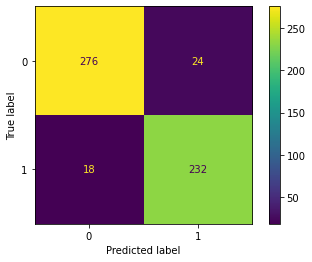

In [101]:
plot_confusion_matrix(best_grid,X_train, y_train,values_format='d' )

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


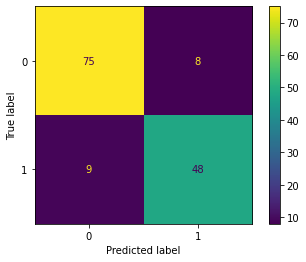

In [102]:
plot_confusion_matrix(best_grid,X_test, y_test,values_format='d' )

In [105]:
models = ['Logistic Regression - L2','Logistic Regression - L1','K-Nearest Neighbors','Decision Tree','Linear Discriminant Analysis', 'Random Forest']
df = pd.DataFrame(models)
test_acc1 = [ '%.4f' % elem for elem in testaccuracy ]
TPR_list1 = [ '%.4f' % elem for elem in tpr_list ]
TNR_list1 = [ '%.4f' % elem for elem in tnr_list ]
AUC_list1 = [ '%.4f' % elem for elem in auc_list ]
df['Accuracy Score'] = test_acc1
df['True Positive Rate - Recall'] = TPR_list1
df['True Negative Rate - Precision'] = TNR_list1
df['AUC ROC'] = AUC_list1
headers = ['Model','Accuracy Score', 'TPR - Precision','TNR - Recall','AUC ROC']
print(tabulate(df, headers=headers, tablefmt="fancy_grid"))

╒════╤══════════════════════════════╤══════════════════╤═══════════════════╤════════════════╤═══════════╕
│    │ Model                        │   Accuracy Score │   TPR - Precision │   TNR - Recall │   AUC ROC │
╞════╪══════════════════════════════╪══════════════════╪═══════════════════╪════════════════╪═══════════╡
│  0 │ Logistic Regression - L2     │           0.8786 │            0.8596 │         0.8916 │    0.9317 │
├────┼──────────────────────────────┼──────────────────┼───────────────────┼────────────────┼───────────┤
│  1 │ Logistic Regression - L1     │           0.8571 │            0.8596 │         0.8554 │    0.9328 │
├────┼──────────────────────────────┼──────────────────┼───────────────────┼────────────────┼───────────┤
│  2 │ K-Nearest Neighbors          │           0.8643 │            0.7895 │         0.9157 │    0.9222 │
├────┼──────────────────────────────┼──────────────────┼───────────────────┼────────────────┼───────────┤
│  3 │ Decision Tree                │         